In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotifyclassification/data.csv


In [2]:
spotify_df = pd.read_csv(r"/kaggle/input/spotifyclassification/data.csv")
spotify_df=spotify_df.drop(columns=['Unnamed: 0'])
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [3]:
import re
import sys
from hashlib import sha1

from IPython.display import Image

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz

train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)

In [4]:
len(train_df), len(test_df)

(1613, 404)

In [5]:
spotify_summary = train_df.describe()
spotify_summary

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [6]:
range_value = spotify_summary.loc['max',:]-spotify_summary.loc['min',:]
largest_range_feature = range_value[range_value == range_value.max()].index[0]
largest_range_feature 

'duration_ms'

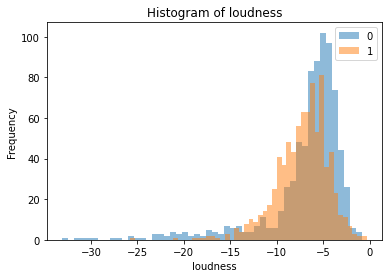

In [7]:
feat = "loudness"
train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, title = "Histogram of " + feat);
plt.xlabel(feat);

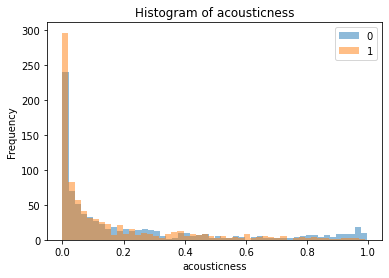

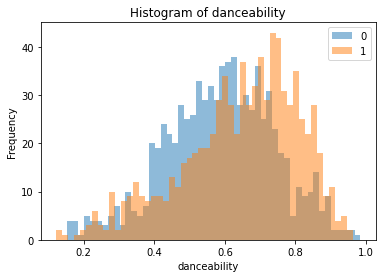

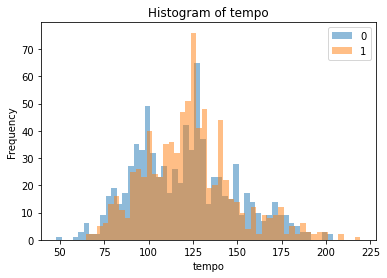

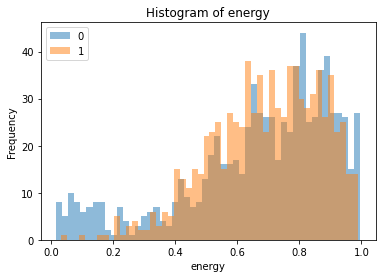

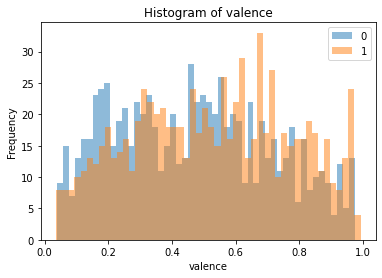

In [8]:
column_hist = ['acousticness','danceability','tempo','energy','valence']
for i in column_hist:
    feat = i
    train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, title = "Histogram of " + feat);
    plt.xlabel(feat);
    plt.show()

In [9]:
spotify_df.describe(include="all")

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017,2017
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1956,1343
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,River,Drake
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,16
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702,NaN,NaN
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091,NaN,NaN
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000,NaN,NaN
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000,NaN,NaN
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000,NaN,NaN
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000,NaN,NaN


In [10]:
X = spotify_df.drop(["target","song_title","artist"],axis=1)
y = spotify_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=123)

In [11]:
model = cross_validate(DummyClassifier(strategy="most_frequent",random_state=123),X_train,y_train,cv=10)
dummy_score = np.mean(model['test_score'])
dummy_score

0.5077524729698643

In [12]:
spotify_tree = DecisionTreeClassifier(random_state=123)

In [13]:
dt_scores_df = pd.DataFrame(cross_validate(spotify_tree,X_train,y_train,cv=10,return_train_score=True))
dt_scores_df

,fit_time,score_time,test_score,train_score
0,0.023075,0.003155,0.722222,0.999311
1,0.017952,0.002678,0.660494,1.000000
2,0.017778,0.002072,0.660494,0.999311
3,0.018121,0.001818,0.677019,1.000000
4,0.017066,0.001990,0.695652,0.999311
5,0.017588,0.001869,0.652174,0.999311
6,0.017127,0.001895,0.658385,0.999311
7,0.018436,0.001908,0.608696,0.999311
8,0.018053,0.001988,0.683230,0.999311
9,0.018078,0.002267,0.695652,0.999311


In [14]:
print(dt_scores_df.test_score.mean())
print(dt_scores_df.train_score.mean())

0.6714017329959358
0.9994489408843148


In [15]:
depths = np.arange(1, 25, 2)
depths

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

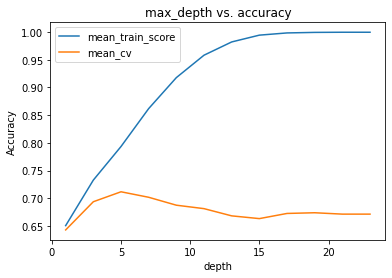

In [16]:
# max_depth_plot: the figure plotted for this exercise
results_dict = {
    "depth": [],
    "mean_train_score": [],
    "mean_cv": [],
}

for depth in depths:
    model = DecisionTreeClassifier(max_depth=depth,random_state=123)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")

max_depth_plot = results_df[["mean_train_score", "mean_cv"]].plot(title="max_depth vs. accuracy", ylabel="Accuracy");

In [17]:
best_max_depth = results_dict['depth'][np.argmax(results_dict["mean_cv"])]
# results_dict
best_max_depth

5

In [18]:
best_model = DecisionTreeClassifier(max_depth=best_max_depth,random_state=123)
best_model.fit( X_train, y_train)
test_score = best_model.score(X_test, y_test)
test_score

0.7178217821782178

In [19]:
results_df

,mean_train_score,mean_cv
depth,,
1,0.650686,0.642926
3,0.732797,0.693766
5,0.793346,0.711705
7,0.861749,0.701791
9,0.917614,0.687505
11,0.958050,0.681294
13,0.981952,0.668273
15,0.994214,0.663323
17,0.998209,0.672632


In [20]:
# spotify_df = pd.read_csv("data\spotify.csv",index_col=None)
X = spotify_df.drop(["target","song_title","artist"],axis=1)
y = spotify_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, random_state=123)
spotify_tree = DecisionTreeClassifier(random_state=123)
spotify_tree.fit( X_train, y_train)
test_score = spotify_tree.score(X_test, y_test)
test_score

0.6881188118811881

In [21]:
train_score = spotify_tree.score(X_train, y_train)
train_score

0.9993800371977681

In [22]:
feature_importance_df=pd.DataFrame(list(best_model.feature_importances_),
list([best_model.feature_names_in_]))
feature_importance_df.sort_values(0,ascending=False)

,0
instrumentalness,0.266902
energy,0.168273
speechiness,0.127575
loudness,0.118149
danceability,0.113310
valence,0.082457
acousticness,0.050967
duration_ms,0.049663
tempo,0.022705
key,0.000000
